In [4]:
!pip install pycryptodome opencv-python


Saving photomode_08112024_162850.png to photomode_08112024_162850.png


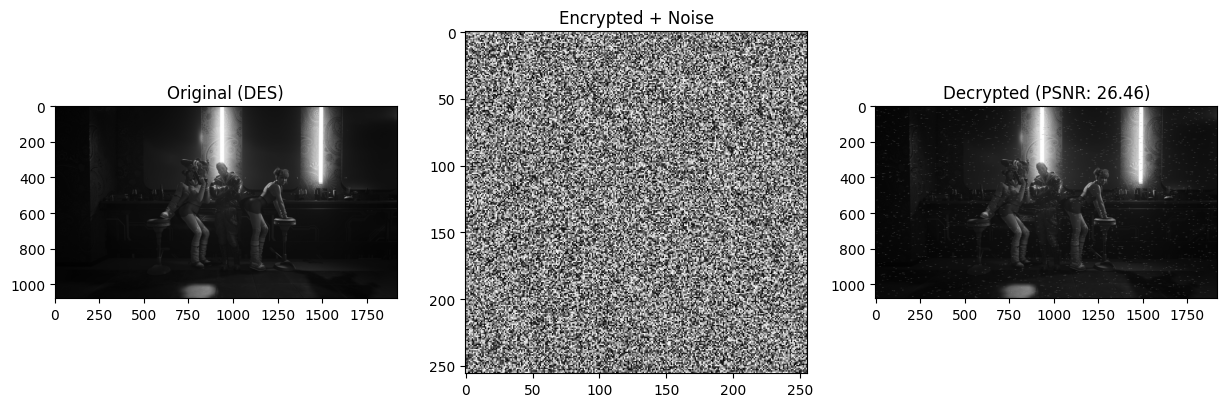

DES Results -> MSE: 146.88, Correlation: 0.9577


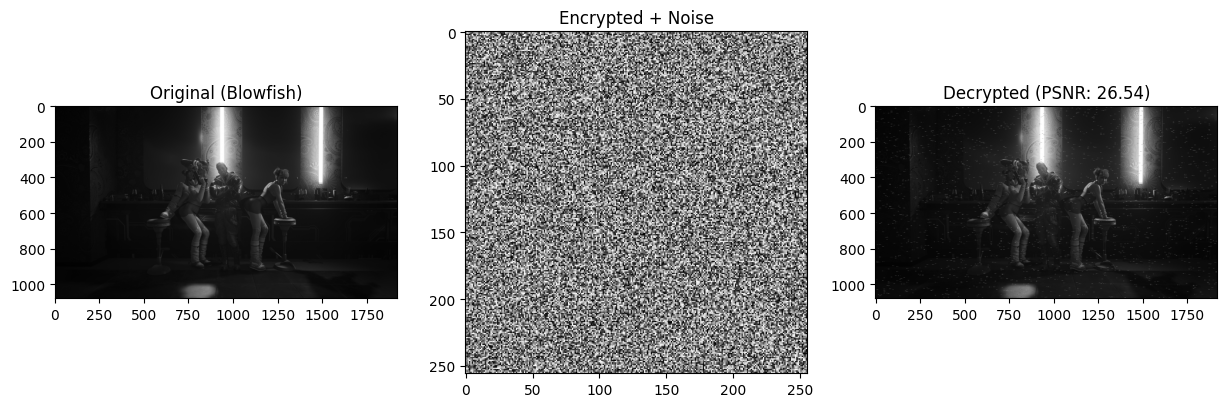

Blowfish Results -> MSE: 144.14, Correlation: 0.9584


In [9]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
from Crypto.Cipher import DES, Blowfish
from Crypto.Util.Padding import pad, unpad
from Crypto.Random import get_random_bytes
from math import log10, sqrt
from google.colab import files

# --- 1. ENCRYPTION & DECRYPTION ENGINES ---
def process_cipher(img_array, key, algo="DES"):
    # Pre-processing: Block ciphers require 8-byte blocks [cite: 1, 181]
    data = img_array.tobytes()
    iv = get_random_bytes(8)

    if algo == "DES":
        cipher = DES.new(key[:8], DES.MODE_CBC, iv)
    else: # Blowfish
        cipher = Blowfish.new(key, DES.MODE_CBC, iv)

    # Encrypt with Padding [cite: 1, 181]
    encrypted_bytes = cipher.encrypt(pad(data, 8))
    encrypted_array = np.frombuffer(encrypted_bytes, dtype=np.uint8)

    return encrypted_array, iv

def decrypt_cipher(enc_data, key, iv, shape, algo="DES"):
    if algo == "DES":
        cipher = DES.new(key[:8], DES.MODE_CBC, iv)
    else:
        cipher = Blowfish.new(key, DES.MODE_CBC, iv)

    decrypted_padded = cipher.decrypt(enc_data.tobytes())
    decrypted_data = unpad(decrypted_padded, 8)
    return np.frombuffer(decrypted_data, dtype=np.uint8).reshape(shape)

# --- 2. NOISE ATTACK & METRICS (From Lecture 8) ---
def apply_noise(enc_data, density=0.0008):
    # Simulate random noise attack [cite: 206, 251]
    attacked = enc_data.copy()
    noise_indices = np.random.rand(*enc_data.shape) < density
    attacked[noise_indices] = np.random.randint(0, 256, np.sum(noise_indices))
    return attacked

def get_performance(orig, recovered):
    # Performance metrics from slides [cite: 224, 230, 231]
    mse = np.mean((orig.astype(float) - recovered.astype(float))**2)
    psnr = 100 if mse == 0 else 20 * log10(255.0 / sqrt(mse))
    corr = np.corrcoef(orig.flatten(), recovered.flatten())[0, 1]
    return mse, psnr, corr

# --- 3. EXECUTION & VISUALIZATION ---
# Upload your image first!
uploaded = files.upload()
filename = list(uploaded.keys())[0]
original = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
key = b'16_byte_secret_k'

algorithms = ["DES", "Blowfish"]

for algo in algorithms:
    # 1. Encrypt
    enc, iv = process_cipher(original, key, algo)

    # 2. Attack
    attacked_enc = apply_noise(enc, density=0.001)

    # 3. Decrypt
    recovered = decrypt_cipher(attacked_enc, key, iv, original.shape, algo)
    mse, psnr, corr = get_performance(original, recovered)


    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1); plt.imshow(original, cmap='gray'); plt.title(f'Original ({algo})')

    # Fix for displaying attacked_enc: Reshape a 256x256 portion of the data
    display_size = 256 * 256
    if attacked_enc.size >= display_size:
        plt.subplot(1, 3, 2); plt.imshow(attacked_enc[:display_size].reshape(256, 256), cmap='gray'); plt.title('Encrypted + Noise')
    else:

        plt.subplot(1, 3, 2); plt.imshow(np.zeros((256,256)), cmap='gray'); plt.title('Encrypted + Noise (Too small)')

    plt.subplot(1, 3, 3); plt.imshow(recovered, cmap='gray'); plt.title(f'Decrypted (PSNR: {psnr:.2f})')
    plt.show()

    print(f"{algo} Results -> MSE: {mse:.2f}, Correlation: {corr:.4f}")

Saving photomode_08112024_162901.png to photomode_08112024_162901 (2).png

--- DES Security Analysis ---
[NOISE] PSNR: 6.00dB | MSE: 16320.13


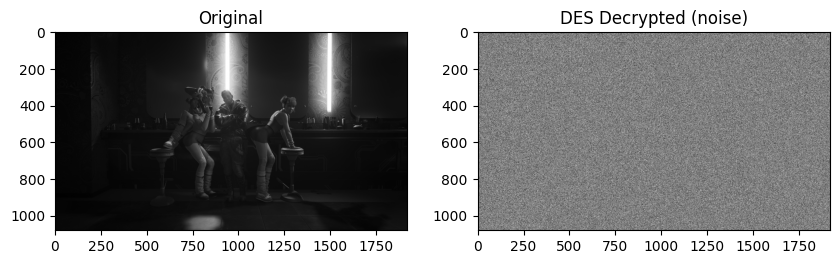

[BLUR] PSNR: 6.00dB | MSE: 16337.58


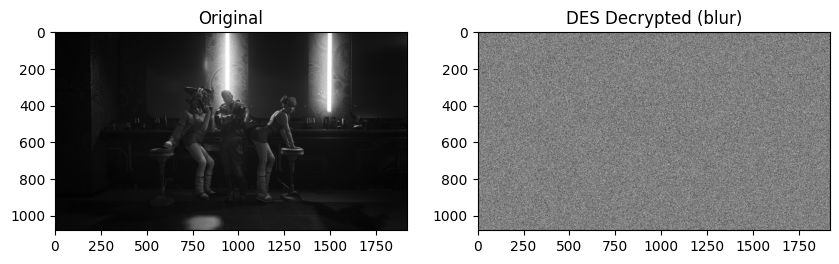

[CROP] PSNR: 11.78dB | MSE: 4316.06


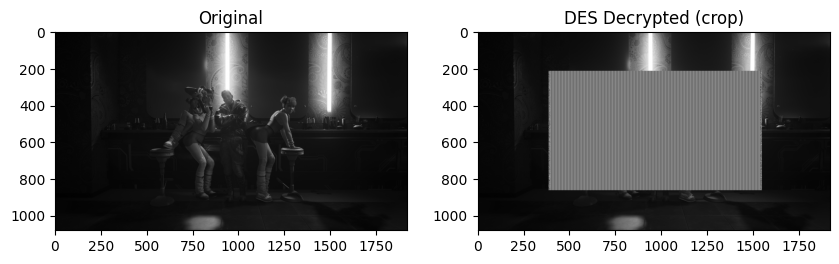


--- Blowfish Security Analysis ---
[NOISE] PSNR: 6.00dB | MSE: 16319.06


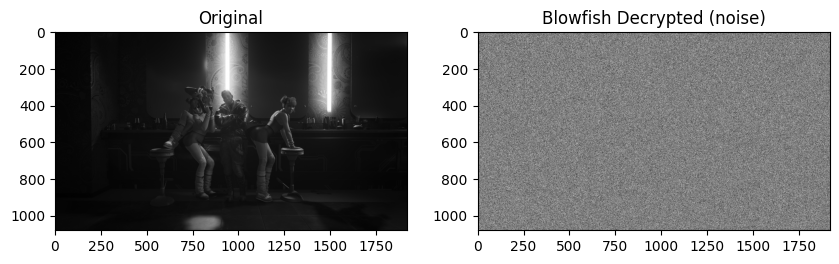

[BLUR] PSNR: 6.00dB | MSE: 16340.05


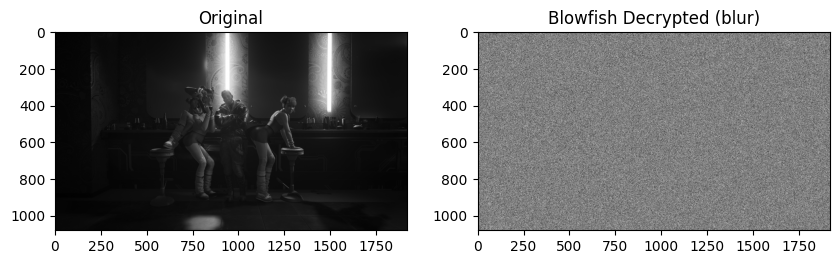

[CROP] PSNR: 10.60dB | MSE: 5658.02


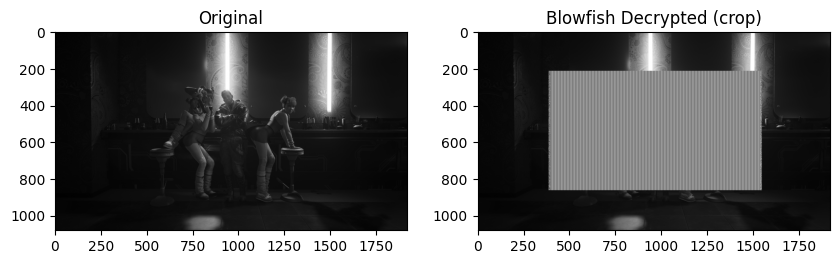

In [11]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
from Crypto.Cipher import DES, Blowfish
from Crypto.Util.Padding import pad, unpad
from Crypto.Random import get_random_bytes
from math import log10, sqrt
from google.colab import files

# --- 1. ENCRYPTION & DECRYPTION ENGINES ---
def encrypt_block(img_array, key, algo="DES"):
    data = img_array.tobytes()
    iv = get_random_bytes(8)
    if algo == "DES":
        cipher = DES.new(key[:8], DES.MODE_CBC, iv)
    else:
        cipher = Blowfish.new(key, DES.MODE_CBC, iv)

    # Pad to 8-byte block size
    padded_data = pad(data, 8)
    encrypted_bytes = cipher.encrypt(padded_data)
    return np.frombuffer(encrypted_bytes, dtype=np.uint8), iv

def decrypt_block(enc_data, key, iv, shape, algo="DES"):
    if algo == "DES":
        cipher = DES.new(key[:8], DES.MODE_CBC, iv)
    else:
        cipher = Blowfish.new(key, DES.MODE_CBC, iv)

    decrypted_raw = cipher.decrypt(enc_data.tobytes())


    try:
        decrypted_data = unpad(decrypted_raw, 8)
    except ValueError:

        decrypted_data = decrypted_raw[:np.prod(shape)]

    return np.frombuffer(decrypted_data, dtype=np.uint8).reshape(shape)

# --- 2. VULNERABILITY SIMULATIONS (Attacks) ---
def apply_simulations(enc_data, shape):
    vulnerabilities = {}
    h, w = shape

    # Noise: Random byte changes
    noise = np.random.randint(0, 50, enc_data.shape)
    vulnerabilities['noise'] = np.clip(enc_data.astype(int) + noise, 0, 255).astype(np.uint8)

    # Blur: Mean filter on ciphertext
    temp_grid = enc_data[:h*w].reshape(h, w)
    blurred_grid = cv2.blur(temp_grid, (3, 3))
    vulnerabilities['blur'] = np.pad(blurred_grid.flatten(), (0, len(enc_data)-h*w), 'constant')

    # Crop: 20% Data Loss
    cropped_grid = temp_grid.copy()
    ch, cw = int(h * 0.2), int(w * 0.2)
    cropped_grid[ch:h-ch, cw:w-cw] = 0
    vulnerabilities['crop'] = np.pad(cropped_grid.flatten(), (0, len(enc_data)-h*w), 'constant')

    return vulnerabilities


def calculate_metrics(orig, recovered):
    mse = np.mean((orig.astype(float) - recovered.astype(float))**2)
    psnr = 100 if mse == 0 else 20 * log10(255.0 / sqrt(mse))
    correlation = np.corrcoef(orig.flatten(), recovered.flatten())[0, 1]
    return mse, psnr, correlation

# --- 4. MAIN EXECUTION ---
uploaded = files.upload()
filename = list(uploaded.keys())[0]
original = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
key = b'16_byte_secret_k'

for algo in ["DES", "Blowfish"]:
    print(f"\n--- {algo} Security Analysis ---")
    enc_data, iv = encrypt_block(original, key, algo)
    sims = apply_simulations(enc_data, original.shape)

    for name, attacked_enc in sims.items():
        recovered = decrypt_block(attacked_enc, key, iv, original.shape, algo)
        mse, psnr, corr = calculate_metrics(original, recovered)

        print(f"[{name.upper()}] PSNR: {psnr:.2f}dB | MSE: {mse:.2f}")

        plt.figure(figsize=(10, 3))
        plt.subplot(1, 2, 1); plt.imshow(original, cmap='gray'); plt.title('Original')
        plt.subplot(1, 2, 2); plt.imshow(recovered, cmap='gray'); plt.title(f'{algo} Decrypted ({name})')
        plt.show()